# Speech Understanding 
# Lecture 8: synthesizing isolated vowels using numpy



### Mark Hasegawa-Johnson, KCGI

In today's lecture, we will learn how to record an audio file directly in python.  We will learn how to analyze its spectrum, in order to get information that can be used to synthesize an artificial vowel.

Here are the contents:
1. [Recording audio in jupyter: ipywebrtc](#section_ipywebrtc)
1. [Converting between different audio file formats: ffmpeg](#section_ffmpeg)
1. [Speech synthesis: Basic concepts](#section_concepts)
1. [Analyzing the peak of the vowel using numpy](#section_numpy)
1. [Making a synthetic vowel](#section_synthesis)
1. [Homework for Week 5](#homework)

<a id='section_ipywebrtc'></a>

## 1.  Recording audio in jupyter: [ipywebrtc](https://ipywebrtc.readthedocs.io/en/latest/)

The [ipywebrtc](https://ipywebrtc.readthedocs.io/en/latest/) module enables you to record audio or video directly into jupyter.  First you need to install it.  The following block uses a shell command (`!`) to tell your computer to install it:

In [1]:
!pip install ipywebrtc

Once you have done that, you should be able to run the following block.  This will create a recorder:

In [2]:
from ipywebrtc import AudioRecorder, CameraStream
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

Now let's look at what was returned:

In [3]:
print(recorder)

AudioRecorder(audio=Audio(value=b'\x1aE\xdf\xa3\x01\x00\x00\x00\x00\x00\x00\x1fB\x86\x81\x01B\xf7\x81\x01B\xf2\x81\x04B\xf3\x81\x08B\x82\x84webmB\x87\x81\x02B...', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': False}))


Notice that this is a structured object, with the following member data:

* audio - the Audio part of the recorded stream
    * value - the recorded waveform (binary data)
    * format - the encoding format (in this case, 'webm')
* stream - the CameraStream from which data was recorded
    * constraints - constraints specified when CameraStream was created
        * audio - True
        * video - False

In order to use the recorded audio, we need to save the data `recorder.audio.value` to a file whose file type is `recorder.audio.format`.

In [6]:
filename = "recording." + recorder.audio.format

with open(filename,'wb') as f:
    f.write(recorder.audio.value)
    
print("Here are statistics about",filename,":\n")
import os
print(os.stat(filename))

Here are statistics about recording.webm :

os.stat_result(st_mode=33188, st_ino=13110732509, st_dev=16777220, st_nlink=1, st_uid=501, st_gid=20, st_size=63224, st_atime=1685472324, st_mtime=1685472344, st_ctime=1685472344)


<a id='section_ffmpeg'></a>

## 2. Converting between different audio file formats: [ffmpeg](https://ffmpeg.org/)

* `ipywebrtc` records audio in [webm](https://www.webmproject.org/) format
* [webm](https://www.webmproject.org/) files are compressed using the [opus](https://opus-codec.org/) open-source audio compression algorithm
* Unfortunately, there is not yet any python library that can convert [webm](https://www.webmproject.org/) files into ordinary wav files!
* Therefore, the only way that you can work with this file is by installing some type of conversion software, such as [ffmpeg](https://ffmpeg.org/)

#### Recommended procedure:

1. Follow the instructions on [https://ffmpeg.org/](https://ffmpeg.org/) to download and install [ffmpeg](https://ffmpeg.org/)
1. After you have done that, the following block should work without errors.

```
ffmpeg -i recording.webm -ac 1 recording.wav
```



In [7]:
!ffmpeg -i recording.webm -ac 1 recording.wav

ffmpeg version 5.0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 13.1.6 (clang-1316.0.21.2.5)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.0.1_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-videotoolbo

#### Alternate procedure, if the above doesn't work for you:

Record your own voice using [praat](https://www.fon.hum.uva.nl/praat/), and save it as `recording.wav`.


#### Read the soundfile, and test that you can hear it and see it

Now you should be able to read in the waveform, plot it, and listen to it.

For reading in audio files, there are many tools available; I recommend  `soundfile`.  You can install it using this block:

In [9]:
!pip install soundfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.3 MB/s eta 0:00:00a 0:00:01


... then you can use it to read your recorded waveform as shown here ...

In [10]:
import soundfile as sf

speech_wave, speech_rate = sf.read("recording.wav")

print("")
print("The file recording.wav is sampled at a frequency of", speech_rate, "samples per second")
print("It contains", len(speech_wave), "samples of audio, i.e.,", len(speech_wave)/speech_rate, "seconds")


The file recording.wav is sampled at a frequency of 48000 samples per second
It contains 232968 samples of audio, i.e., 4.8535 seconds


In [ ]:
import IPython

IPython.display.Audio(data=speech_wave, rate=speech_rate)

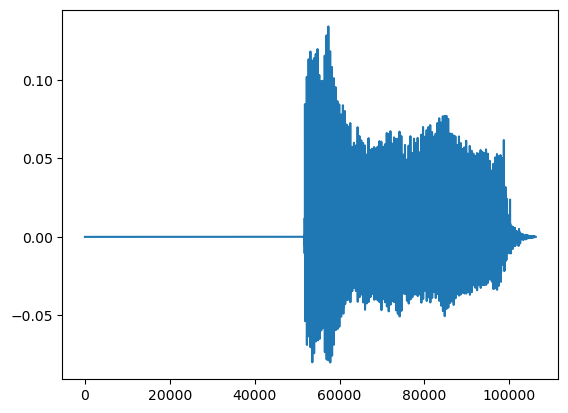

In [8]:
import matplotlib.pyplot as plt

plt.plot(speech_wave)

<a id='section_concepts'></a>

## 3. Speech synthesis: Basic concepts

Speech is composed of a **source**, whose spectrum is adjusted by a **filter**.  

### Source: Voiced or Unvoiced

* Voiced speech is excited by vibration of the vocal folds.  The vocal folds vibrate at a frequency that we call the "pitch frequency," usually written as $F_0$.  The speech signal then contains sine waves at every integer multiple of $F_0$: 
$$x(t)=\sin(2\pi F_0t)+\sin(4\pi F_0t)+\sin(6\pi F_0t)+\sin(8\pi F_0t)+\cdots$$

* Unvoiced speech is excited by noise, generated by blowing air against your teeth, or against the roof of your mouth.

### Filter

* The **filter** changes the amplitudes of each sine wave, or the amplitude of the noise, giving something like:

$$x(t)=A_1 \sin(2\pi F_0t)+A_2 \sin(4\pi F_0t)+A_3 \sin(6\pi F_0t)+A_4\sin(8\pi F_0t)+\cdots$$

* $F_0$ determines the **pitch** of the vowel.  The amplitudes, $A_1,\ldots$, determine **which vowel it is**.  All of the frequency components up to 2500Hz are important for determining which vowel it is; see the [Wikipedia page about vowels](https://en.wikipedia.org/wiki/Vowel) for some good example spectra.

### More about the source-filter model

* The source-filter model was used in an AT&T speech synthesizer for the 1939 World's Fair in New York city.  The [video](https://www.youtube.com/watch?v=5hyI_dM5cGo) is well worth watching.

* The first complete description of vowels was written by Chiba and Kajiyama, in 1940.  It is described [here](https://en.wikipedia.org/wiki/Source%E2%80%93filter_model)


<a id='section_numpy'></a>

## 4. Analyzing the peak of the vowel using [numpy](https://numpy.org/doc/stable/user/absolute_beginners.html)

In order to synthesize a copy of the same vowel, we need to learn more about it.

First, we need to extract a small segment, about 0.1 seconds, near the peak of the vowel.  We can do that by using `np.argmax` to find the peak, then choosing a slice starting 0.05 seconds earlier, and ending 0.05 seconds later.

The peak is at sample number 57364


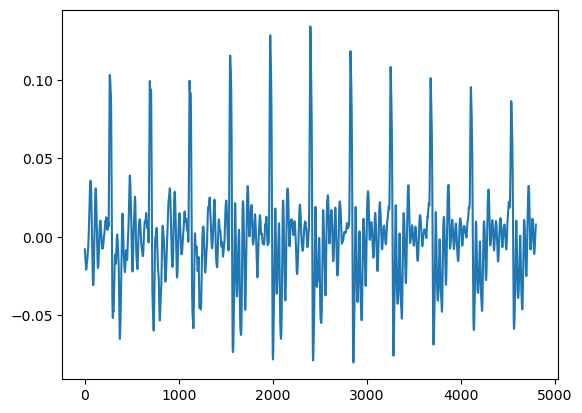

In [9]:
import numpy as np

peak_sample = np.argmax(np.abs(speech_wave))
print('The peak is at sample number',peak_sample)

segment_start = peak_sample - int(0.05*speech_rate)
segment_end = peak_sample + int(0.05*speech_rate)
speech_segment = speech_wave[segment_start:segment_end]

plt.plot(speech_segment)


In order to synthesize it, we need to find out 

* the frequencies and 
* the amplitudes 

of the most important sine waves.  Let's try plotting the spectrum.

Text(0.5, 0, 'Frequency (Hz)')

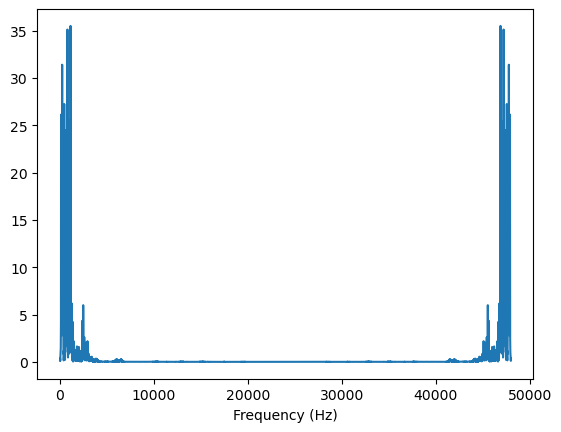

In [10]:
speech_frequencies = np.linspace(0,speech_rate,len(speech_segment))
speech_spectrum = np.abs(np.fft.fft(speech_segment))
plt.plot(speech_frequencies, speech_spectrum)
plt.xlabel('Frequency (Hz)')

Clearly, we need to zoom in a little...

Text(0.5, 0, 'Frequency (Hz)')

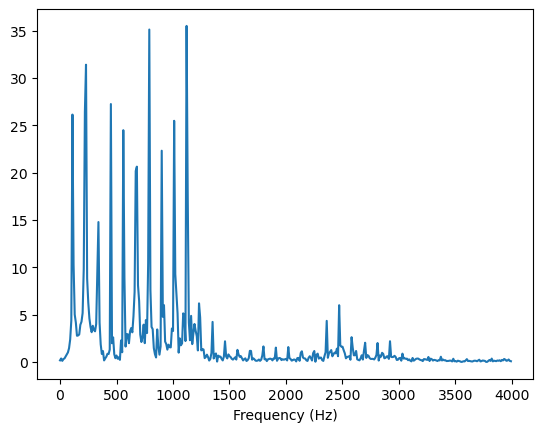

In [11]:
plt.plot(speech_frequencies[:400], speech_spectrum[:400])
plt.xlabel('Frequency (Hz)')

That plot shows the frequencies and amplitudes of the three most important sine waves pretty clearly.  To find the frequencies and amplitudes of the others, we can try adjusting the axis limits using the [plt.axis](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axis.html) command.  This command takes a list with four elements:
1. xmin
1. xmax
1. ymin
1. ymax

(0.0, 4000.0, 0.0, 50.0)

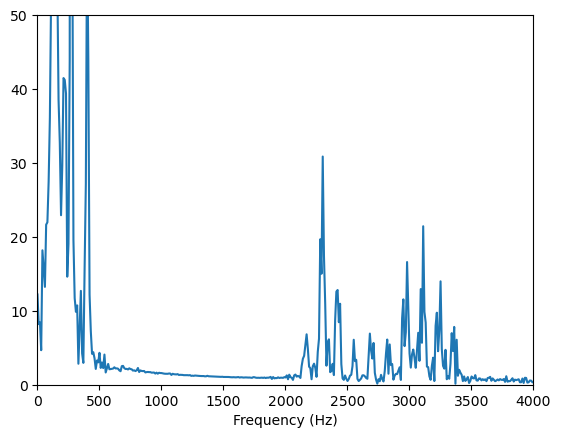

In [11]:
plt.plot(speech_frequencies[:400], speech_spectrum[:400])
plt.xlabel('Frequency (Hz)')
plt.axis([0,4000,0,50])

It's much more interesting to plot just a few cycles of the sine wave.  If there are 500 cycles per second, then 0.01 seconds will give us 5 cycles:

<a id="section_synthesis"></a>

## 4. Do-it-yourself speech synthesis

Try to find eight frequencies in the spectrum, including 4 below 1000Hz, and 4 above 1000Hz.  Here are some hints, to make your synthetic vowel sound better:

* At least four of the frequencies should be above 1000Hz.
* Usually, all of the frequencies will be multiples of your pitch frequency.  So if your pitch frequency is 140Hz, then the first three frequencies might be $140$, $280$, and $420$, and then there might be another one at $2240$ ($=140*16$), and another four at $2940, 3080$, $3220$, and $3360$ ($=140*21$, $22$, $23$, and $24$).
* Find the amplitudes by reading them off the Y-axis.

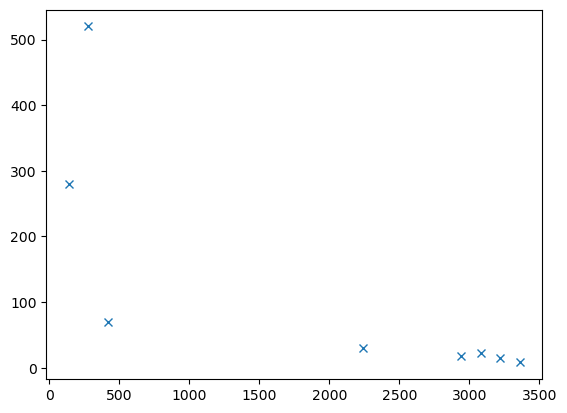

In [14]:
synthesis_frequencies = [140, 280, 420, 2240, 2940, 3080, 3220, 3360]
synthesis_amplitudes = [280, 520, 70, 30, 18, 22, 15, 8]
plt.plot(synthesis_frequencies, synthesis_amplitudes, 'x')

Now let's create a synthetic speech signal by creating sine waves at all of those frequencies, scaled by those amplitudes:

Adding the sine wave at  (140, 280)
Adding the sine wave at  (280, 520)
Adding the sine wave at  (420, 70)
Adding the sine wave at  (2240, 30)
Adding the sine wave at  (2940, 18)
Adding the sine wave at  (3080, 22)
Adding the sine wave at  (3220, 15)
Adding the sine wave at  (3360, 8)


Text(0.5, 1.0, 'Synthetic Vowel')

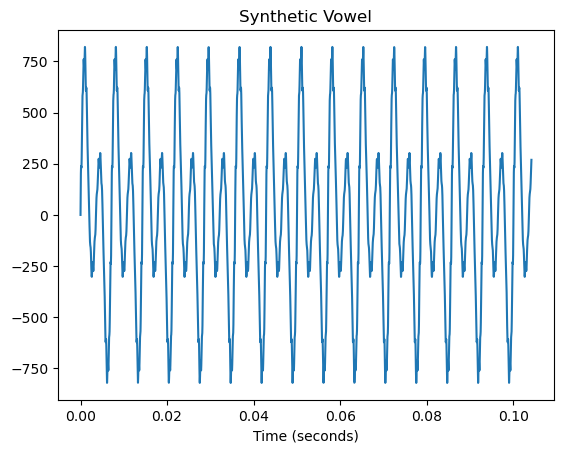

In [15]:
synthetic_timeaxis = np.linspace(0,0.5, int(0.5*speech_rate))
synthetic_speech = np.zeros(len(synthetic_timeaxis))

for (frequency,amplitude) in zip(synthesis_frequencies, synthesis_amplitudes):
    print('Adding the sine wave at ',(frequency,amplitude))
    synthetic_speech += amplitude * np.sin(2*np.pi*frequency*synthetic_timeaxis)

plt.plot(synthetic_timeaxis[:5000],synthetic_speech[:5000])
plt.xlabel('Time (seconds)')
plt.title('Synthetic Vowel')

The waveform doesn't look so similar... Let's try plotting the spectrum.

Text(0.5, 1.0, 'Spectrum of Synthetic Vowel')

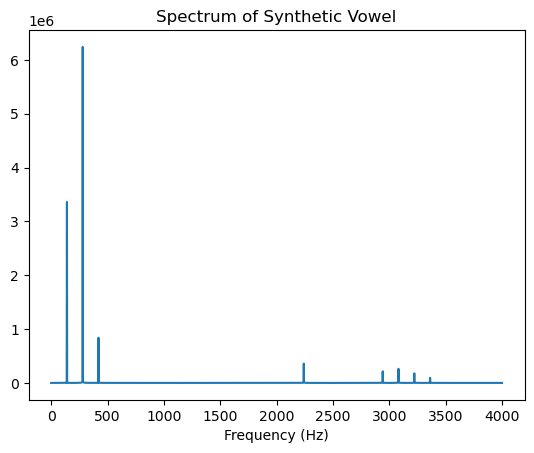

In [16]:
synthetic_spectrum = np.abs(np.fft.fft(synthetic_speech))
synthetic_frequencies = np.linspace(0,speech_rate, len(synthetic_speech))
plt.plot(synthetic_frequencies[:2000],synthetic_spectrum[:2000])
plt.xlabel('Frequency (Hz)')
plt.title('Spectrum of Synthetic Vowel')

Let's try playing it back:

In [17]:
import IPython

IPython.display.Audio(data=synthetic_speech, rate=speech_rate)

<a id="homework"></a>

## Homework for Week 5

Homework will be manually graded on Gradescope.  Submit 2 PNG files:

1. `aa_natural_spectrum.png` should show the spectrum of you saying `aa`.  It should only show the first 4000Hz.  There should be a peak at your pitch frequency, another peak at about 900Hz, and another peak at about 1100Hz.
1. `aa_synthetic_spectrum.png` should show the spectrum of your synthesized `aa` vowel.  It should show the first 4000Hz.  There should be a sine wave at your pitch frequency, another at a multiple of your pitch frequency near 900Hz, and another at a multiple of your pitch frequency near 1100Hz.